<a href="https://colab.research.google.com/github/ffarishta/Satellite-Cloud-Images-Classification/blob/main/EfficientNetB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import Callback
import multiprocessing
import keras.backend as K
from tensorflow.keras.optimizers import Adam


In [3]:
df = pd.read_csv('/content/drive/MyDrive/understanding_cloud_organization/train.csv')
num_cores = multiprocessing.cpu_count()



In [4]:
df = df[~df['EncodedPixels'].isnull()].copy()

df['Image'] = df['Image_Label'].map(lambda x: x.split('_')[0])
df['Class'] = df['Image_Label'].map(lambda x: x.split('_')[1])

classes = df['Class'].unique()

# Group and reset index
df = df.groupby('Image')['Class'].agg(set).reset_index()

# Add columns for each class
for class_name in classes:
    df[class_name] = df['Class'].map(lambda x: 1 if class_name in x else 0)

df.head()


,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Fish, Flower, Sugar}",1,1,1,0
2,0031ae9.jpg,"{Fish, Flower, Sugar}",1,1,1,0
3,0035239.jpg,"{Flower, Gravel}",0,1,0,1
4,003994e.jpg,"{Fish, Gravel, Sugar}",1,0,1,1


In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[classes])

In [6]:
class AlbumentationsDataGenerator(Sequence):
    def __init__(self, dataframe, directory, batch_size=32, target_size=(224, 224),
                 shuffle=True, augmentation=None, class_columns=None):
        self.dataframe = dataframe.copy()
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if class_columns is None:
            self.class_columns = dataframe.columns[2:]
        else:
            self.class_columns = class_columns

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            row = self.dataframe.iloc[i]
            image = cv2.imread(os.path.join(self.directory, row['Image']))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.target_size)

            if self.augmentation:
                augmented = self.augmentation(image=image)
                image = augmented['image']

            # Convert image to float32 and normalize
            batch_images.append(image.astype('float32') / 255.0)

            # Convert label to float32
            batch_labels.append(row[self.class_columns].astype('float32'))

        return np.array(batch_images), np.array(batch_labels)


# Define the augmentation pipeline
albumentations_train = Compose([
    VerticalFlip(),
    HorizontalFlip(),
    Rotate(limit=20),
    GridDistortion()
], p=1)


In [7]:
train_dataset_path = "/content/drive/MyDrive/understanding_cloud_organization/train_images"
train_generator = AlbumentationsDataGenerator(
    dataframe=train_df,
    directory=train_dataset_path,
    batch_size=32,
    target_size=(224, 224),
    shuffle=True,
    augmentation=albumentations_train,
    class_columns=classes
)

test_generator = AlbumentationsDataGenerator(
    dataframe=test_df,
    directory=train_dataset_path,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False,
    augmentation=None,
    class_columns=classes
)

In [8]:
import efficientnet.keras as efn

def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB2(weights='imagenet', include_top=False, pooling='avg', input_shape=(260, 260, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()


In [56]:
model.save('model.keras')


In [9]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = False
num_cores = multiprocessing.cpu_count()
model.compile(optimizer="Adam",  loss='categorical_crossentropy', metrics=['accuracy'])
history_0 = model.fit_generator(generator=train_generator,
                              validation_data=test_generator,
                              epochs=13,
                              workers=num_cores,
                              verbose=1
                             )

<ipython-input-9-2f9c21280c37>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_0 = model.fit_generator(generator=train_generator,


Epoch 1/13
139/139 [==============================] - 308s 2s/step - loss: 2.9267 - accuracy: 0.2622 - val_loss: 2.8437 - val_accuracy: 0.3811
Epoch 2/13
139/139 [==============================] - 290s 2s/step - loss: 2.8499 - accuracy: 0.3476 - val_loss: 2.8078 - val_accuracy: 0.3757
Epoch 3/13
139/139 [==============================] - 284s 2s/step - loss: 2.8369 - accuracy: 0.3729 - val_loss: 2.8266 - val_accuracy: 0.3649
Epoch 4/13
139/139 [==============================] - 290s 2s/step - loss: 2.8388 - accuracy: 0.3704 - val_loss: 2.8257 - val_accuracy: 0.4658
Epoch 5/13
139/139 [==============================] - 290s 2s/step - loss: 2.8521 - accuracy: 0.3826 - val_loss: 2.7833 - val_accuracy: 0.3892
Epoch 6/13
139/139 [==============================] - 279s 2s/step - loss: 2.8495 - accuracy: 0.3688 - val_loss: 2.8025 - val_accuracy: 0.4360
Epoch 7/13
139/139 [==============================] - 285s 2s/step - loss: 2.8712 - accuracy: 0.3846 - val_loss: 2.8142 - val_accuracy: 0.4081

In [31]:
import keras
import tensorflow as tf
for base_layer in model.layers[:-3]:
    base_layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])
history_1 = model.fit_generator(generator=train_generator,
                              validation_data=test_generator,
                              epochs=2,
                              workers=num_cores,
                              verbose=1
                             )

<ipython-input-31-f4b84ec81704>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1 = model.fit_generator(generator=train_generator,


Epoch 1/2
139/139 [==============================] - 382s 2s/step - loss: 12.9353 - accuracy: 0.5014 - auc_2: 0.5000 - val_loss: 18.2954 - val_accuracy: 0.5018 - val_auc_2: 0.5000
Epoch 2/2
139/139 [==============================] - 296s 2s/step - loss: 12.7689 - accuracy: 0.5014 - auc_2: 0.5000 - val_loss: 16.8879 - val_accuracy: 0.5018 - val_auc_2: 0.5000


In [27]:
def plot_acc_err(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    print("\n")
    # Error
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

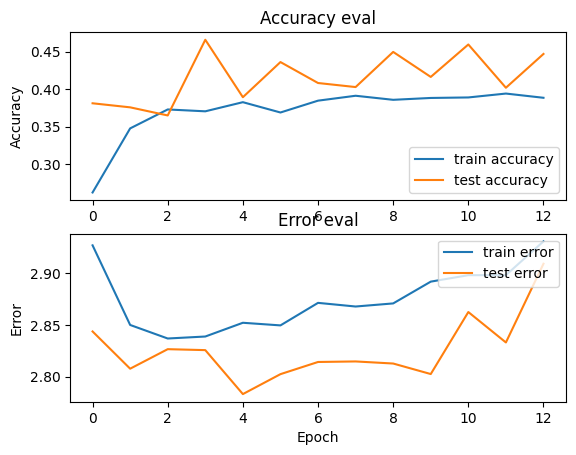

In [32]:
plot_acc_err(history_0)


In [34]:
y_pred_probs = model.predict(train_generator).ravel()


139/139 [==============================] - 274s 2s/step


In [45]:
print("The AUC score on the validation set is:", history_1.history['val_accuracy'][-1])

The AUC score on the validation set is: 0.5018017888069153
